# Signal Template Matching (1-D case)


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_discrete(discrete_signal, label = '', show = True):
    plt.plot(discrete_signal)
    plt.ylabel(label)
    plt.xticks(np.arange(0, len(discrete_signal), 1))
    if show:
        plt.show()    

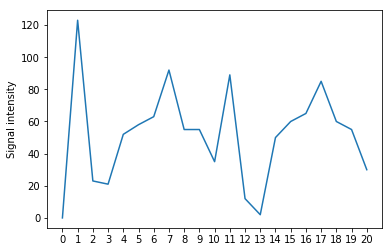

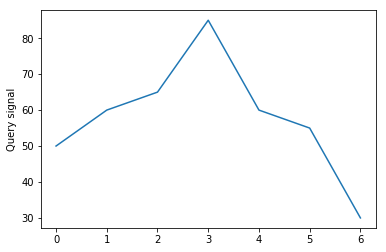

In [3]:
#Pattern signal h(j)
h = pattern_to_find = np.array([50, 60, 65, 85, 60, 55, 30])
N = len(pattern_to_find)

# Input signal f(j)
input_signal = np.array([0, 123, 23, 21, 52, 58, 63, 92, 55, 55, 35, 89, 12, 2, 50, 60, 65, 85, 60, 55, 30])
f = np.pad(input_signal, [(0, N)], mode='constant')
M = len(input_signal)
plot_discrete(input_signal, label='Signal intensity')


plot_discrete(pattern_to_find, label='Query signal')



## How to detect pattern entries?
Note, there are two entries of signal  

In [4]:
print(pattern_to_find) 

[50 60 65 85 60 55 30]


at position 4 and 14: 

In [5]:
print(input_signal[4:4+N])

[52 58 63 92 55 55 35]


In [6]:
print(input_signal[14:14+N])

[50 60 65 85 60 55 30]


### 1. Bruteforce approach

Run search at every point. Let's start with $s(m) = \sum\limits_{k=0}^{N-1} [f(m + k) - h(k)] ^ 2 $ :

Run search at every poi

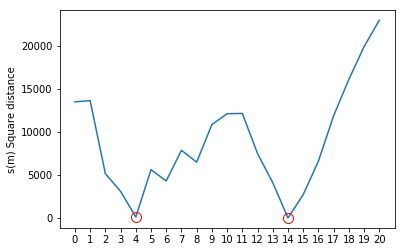

In [7]:
#Run search at every poi
def sq(m):
    return np.sum(np.square(f[m:m+N]-h))

g_values = [sq(x) for x in range(M)]

plot_discrete(g_values, label='s(m) Square distance', show=False)
plt.plot(4, g_values[4], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.plot(14, g_values[14], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.show()


#### Problems?
1. Total number of calculations needed: $ O(|f|\cdot|h|) $ 
For instance, if signal $f$ has 10000 points and pattern $h$ is 100 points the will be roughly 
$ 100 \times 10000 $ summations and multiplications and even harder for 2-D case!
2. Signal is not normalized and not centered
3. Depends on scale.

### 2. Normalized Cross Correlation
First of all, let's take a look at the formula. 

$
 s(m) = \sum\limits_{k=0}^{N-1} [f(m + k) - h(k)] ^ 2 =
 \sum\limits_{k=0}^{N-1} f^2(m + k) - \sum\limits_{k=0}^{N-1} 2 f(m+k)h(k) + \sum\limits_{k=0}^{N-1} h^2(k)  
$

* $\sum\limits_{k=0}^{N-1} h^2(k)$ is constant  - ignore it
* $ \sum\limits_{k=0}^{N-1} f^2(m + k) $  - might be ignored if it's approximately constant

In other words, we might be interested only in "cross-correlation":

$ c(m) = \sum\limits_{k=0}^{N-1} f(m+k)h(k) $

Note: numpy has `np.correlate(f, h)` = $ c(m) $ 
Note: scipy has `scipy.signal.correlate(f, h)` = $ c(m) $ 

Let's plot it!


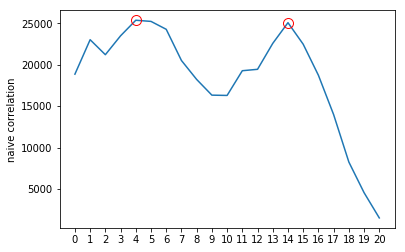

In [8]:
def cross_naive(m):
    # residual length
    return np.dot(f[m:m+N], h)

naive_plot = [cross_naive(m) for m in range(M)]
plot_discrete(naive_plot, label='naive correlation', show=False)
plt.plot(4, naive_plot[4], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.plot(14, naive_plot[14], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.show()



Actual normalized cross-correlation $ \gamma(m) $ is given as: 

$ \gamma(m) =  \frac{\sum\limits_{k=0}^{N-1}\hat{f}_m(k) \times \hat{h}(k) }{ \lVert \hat{f}_m \rVert \times \lVert \hat{h} \rVert } $, where: 

$ \hat{h}(m) = h(m) - \frac{1}{N}\sum\limits_{k=0}^{N-1}h(k) $

$ \hat{f}_m(j) = f(m + j) - \frac{1}{N}\sum\limits_{k=0}^{N-1}f(m + k)  $.



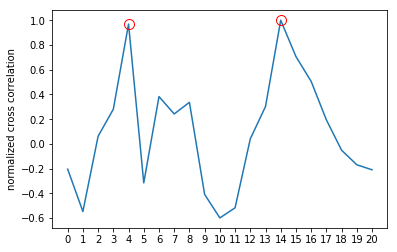

In [9]:
h_hat = h - np.average(h)
def f_hat(m):
    f_hat_window = f[m:m+N]
    # diy:: try removing average over f_hat_window and see charts!
    return f_hat_window - np.average(f_hat_window)
    
def cross_corr_norm(m):
    f_hat_window = f_hat(m)
    return np.dot(f_hat_window, h_hat)/\
           (np.linalg.norm(f_hat_window) * np.linalg.norm(h_hat))

normalized_cc_plot = [cross_corr_norm(m) for m in range(M)]
plot_discrete(normalized_cc_plot, label='normalized cross correlation', show=False)
plt.plot(4, normalized_cc_plot[4], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.plot(14, normalized_cc_plot[14], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.show()


### 3. Fast Normalized Cross Correlation
(Lewis, J.P.. (2001). Fast Normalized Cross-Correlation. Ind. Light Magic. 10. )
#### 4.1. Replace denominator with dynamic summs:

$ s(m) = f(m) + s(m-1) $

$ s^2(m) = f^2(m) + s^2(m-1) $ 

Then, "expensive" calculation becomes:

$ \hat{f}_m(j) = f(m + j) - \frac{1}{N}\sum\limits_{k=0}^{N-1}f(m + k) = f(m+j) - \frac{1}{N}(s(m + N - 1) - s(m - 1)) $

$ \lVert \hat{f}_m \rVert = ( \sum\limits_{j=0}^{N-1}\hat{f}^2_m(j))^{1/2} $
  
$ \sum\limits_{j=0}\hat{f}^2_m(j) = \sum\limits_{j=0}^{N-1}(f(m + j) - \frac{1}{N}\sum\limits_{k=0}^{N-1}f(m + k))^2 $
$  = \sum\limits_{j=0}^{N-1}f^2(m + j) - \sum\limits_{j=0}^{N-1}(2 f(m + j)\frac{1}{N}\sum\limits_{k=0}^{N-1}f(m + k)) + \sum\limits_{j=0}^{N-1}\frac{1}{N^2}(\sum\limits_{k=0}^{N-1}f(m + k))^2  $ 
$  = \sum\limits_{j=0}^{N-1}f^2(m + j) - \frac{2}{N} \sum\limits_{k=0}^{N-1}f(m + k) \times \sum\limits_{j=0}^{N-1}f(m + j) + (\sum\limits_{k=0}^{N-1}f(m + k))^2\sum\limits_{j=0}^{N-1}\frac{1}{N^2}  $
$  = \sum\limits_{j=0}^{N-1}f^2(m + j) - \frac{2}{N} (\sum\limits_{k=0}^{N-1}f(m + k))^2 + \frac{1}{N}(\sum\limits_{k=0}^{N-1}f(m + k))^2  $
$  = \sum\limits_{j=0}^{N-1}f^2(m + j) - \frac{1}{N} (\sum\limits_{k=0}^{N-1}f(m + k))^2 $
$  = \sum\limits_{j=0}^{N-1}f^2(m + j) - \frac{1}{N} (\sum\limits_{k=0}^{N-1}f(m + k))^2 $
$  = s^2(m + N - 1) - s^2(m - 1) - \frac{1}{N}(s(m + N - 1) - s(m - 1))^2  $

Let's verify this actually works!

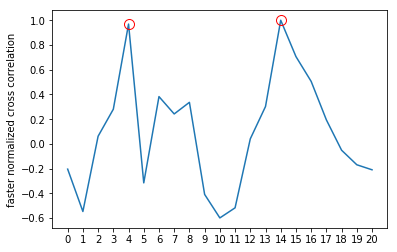

In [10]:
# yes, this approach is that popular so there's a method in numpy
# add zero head
def pad_left(arr):
    return np.pad(arr, [(1,0)], mode='constant')

f_sum = np.cumsum(f) 
f_sum = pad_left(f_sum)
f_sq_sum = np.cumsum(f ** 2)
f_sq_sum = pad_left(f_sq_sum)
h_sq_sum = np.cumsum(h_hat ** 2)
h_sq_sum = pad_left(h_sq_sum)
   
def cross_corr_norm_improved(m):
    f_norm = f_sq_sum[m + N] - f_sq_sum[m] - (f_sum[m + N] - f_sum[m])**2/N
    #centered value, so just calculating norm
    h_norm = h_sq_sum[N]
    return np.dot(f_hat(m), h_hat)/np.sqrt(f_norm * h_norm)
  
faster_cc_plot = [cross_corr_norm_improved(m) for m in range(M)]

plot_discrete(faster_cc_plot, label='faster normalized cross correlation', show=False)
plt.plot(4, faster_cc_plot[4], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.plot(14, faster_cc_plot[14], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.show()


#### 4.2. Improve numerator calculation via Fourier Transform

While it was possible to calculate denominator in under $ O(M) $ operations (instead of $O(N \cdot M) $ ), 
numerator still requires calculation of dot product at every point. 
One of the approaches is to use Fourier transform to decompose dot product.

$ \gamma^{num}(m) =  \sum\limits_{k=0}^{N-1}\hat{f}_m(k) \times \hat{h}(k) $

$ \gamma^{num}(m) =  \sum\limits_{k=0}^{N-1}(f(m + k) - \bar{f}_m)\times \hat{h}(k) $, where
$ \bar{f}_m = \frac{1}{N}\sum\limits_{k=0}^{N-1}f(m + k) $,

taking into the account that 
$ \sum\limits_{k=0}^{N-1} \hat{h}(k) = 0 $, thus

$ \gamma^{num}(m) =  \sum\limits_{k=0}^{N-1}f(m + k) \times \hat{h}(k) $ .
$ \gamma^{num} = \mathcal{F}^{-1}{(\mathcal{F}{f} \mathcal{F}^{*}{\hat{h}})} $,

which can be calculated in $ O(M log_2{M}) $ operations instead of $ O(MN) $ for 1-D case.

Still let's verify that numerator is the same:


In [11]:
numerator_direct = [np.dot(f_hat(m), h_hat) for m in range(M)]
numerator_direct


[-811.4285714285713,
 -1974.2857142857144,
 150.0,
 578.5714285714287,
 1648.5714285714284,
 -632.1428571428571,
 1074.2857142857142,
 838.5714285714284,
 978.5714285714284,
 -1205.7142857142858,
 -1819.2857142857142,
 -1727.142857142857,
 120.71428571428578,
 762.8571428571429,
 1642.857142857143,
 1935.7142857142858,
 1657.1428571428573,
 667.8571428571429,
 -139.2857142857141,
 -367.8571428571428,
 -235.71428571428572]

In [12]:
import scipy.signal as signal
numerator_fft = signal.fftconvolve(f, h_hat[::-1])[N-1:-N]
numerator_fft


array([ -811.42857143, -1974.28571429,   150.        ,   578.57142857,
        1648.57142857,  -632.14285714,  1074.28571429,   838.57142857,
         978.57142857, -1205.71428571, -1819.28571429, -1727.14285714,
         120.71428571,   762.85714286,  1642.85714286,  1935.71428571,
        1657.14285714,   667.85714286,  -139.28571429,  -367.85714286,
        -235.71428571])

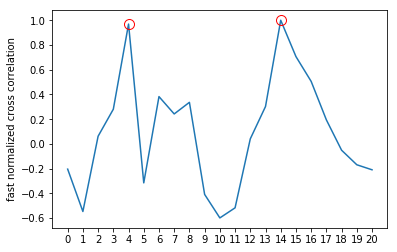

In [15]:
def fast_cross_correlation(m):
    f_norm = f_sq_sum[m + N] - f_sq_sum[m] - (f_sum[m + N] - f_sum[m])**2/N
    #centered value, so just calculating norm
    h_norm = h_sq_sum[N]
    return numerator_fft[m]/np.sqrt(f_norm * h_norm)

fast_cc_plot = [fast_cross_correlation(m) for m in range(M)]
plot_discrete(faster_cc_plot, label='fast normalized cross correlation', show=False)
plt.plot(4, faster_cc_plot[4], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.plot(14, faster_cc_plot[14], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.show()
